<a href="https://colab.research.google.com/github/zdwhite/Thinkful-Unit-4/blob/master/NLP_capstone_Data_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding Similarities in Reddit Online Community using Doc2Vec

## Introduction

  For this project I wanted to see how easy (difficult) it would be to classify online forum comments from the online community [Reddit](www.reddit.com). The hypothesis goes like this, how (dis)similar are certain subreddit (communities) from one another?
  
  The following project will show the language comparrison of four communities on reddit. Here is your one and only **trigger warning**, some of the texts scrapped in this project contain at the bare minimum intellectually challenging/unsavory statements and at the worst outright bigotry. If that makes you uncomfortable turn back now.

The subreddits (communities) to be examied are as follows : Politics, Conspiracy, The_Donald, and Changemyview.

For quick introduction to each community here are there self descriptions:

 * /r/Politics
  >is the subreddit for current and explicitly political U.S. news.
 * /r/Conspiracy
 >This is a forum for free thinking and for discussing issues which have captured your imagination. Please respect other views and opinions, and keep an open mind. Our goal is to create a fairer and more transparent world for a better future.
 
 * /r/The_Donald
 >Welcome to the forum of choice for The President of The United States, Donald Trump!

 >Be advised this forum is for serious supporters of President Trump. We have discussions, memes, AMAs, and more. We are not politically correct. Please read and respect our rules below before contributing
 
 * /r/changemyview
  >A place to post an opinion you accept may be flawed, in an effort to understand other perspectives on the issue. Enter with a mindset for conversation, not debate.
  

# Building the Corpus  

** Skip this if you understand what reddit is.**

First a bit of context is an example of what a submission looks like.

>![alt text](https://www.groovypost.com/wp-content/uploads/2018/03/reddit_commenting.png)

The only submission type that was excluded from the search were submissions known as "self posts".

Next, here is an example of what the nested thread structure of conversation looks like on reddit. The top comment in the image below is called a "parent comment" as it is a direct reply to the submission. Replies to the parent are called "children" and for the purposes of this initial analysis and scraping were not considerd.

However it would not be too dificult to implement them into the corpus.

>![alt text](https://www.groovypost.com/wp-content/uploads/2018/03/reddit-comment-screenshot.png)

Texts were scraped under the following rules:
* The top 50 submission posts of all time for each subreddit were pulled.
* For each submission the parent comments of the first page were extracted. 
* If the comment was deleted by the user it was discarded
  * Note I would later learn I forgot to discard posts marked as "Removed" by moderators 

The idea here is that while each comment is individually authored we can view the collective narative of a particular subreddit as having a mean voice, this is given by the concensus of top comments being voted to the top.


**NOTE:** score is note a direct factor in deciding if a comment became a part of the corpus. 

In [0]:
# Install reddit scraping module and update seaborn  

!pip install praw;
!pip install seaborn -U;

In [0]:
import requests
import praw
import time
import pandas as pd
import json
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

## Scraping Reddit

This section will cover functions that scrape comments from subreddits.

We will be using the PRAW module developed specifically to call from the reddit API.

In [0]:
# Define how PRAW will access reddit

reddit = praw.Reddit(user_agent='Scrape_bot',
                     client_id='_XX9OWL3X9Gv-A', client_secret="vAvTdaG9JYkrjd2Pe2_r5Q3wrIo")

In [0]:
## Define the subreddits you want to scrape the top submissions from.

subreddits = ['politics','The_Donald','changemyview','conspiracy']

## Subreddit Top Submissions

 This function takes in an array of subreddits
 
Returns the top 50 submissions (of all time) for each subreddit
  
Data extracted are as follows ["title","score","id","comms_num","created","subreddit"]

The most important Column is  "id" as this will give us the point of entry for each submission to scrape comments.
    


In [0]:

def scrape_submissions(subreddits):
  submissions_data = pd.DataFrame()
  for sub in subreddits:
    print(sub)
    #sub = reddit.subreddit(sub)
    #print(sub)
    #top_sub = subreddit.top(limit = 50)
    submissions_dict = { "title":[], 
                "score":[], 
                "id":[], 
                #"url":[], 
                "comms_num": [], 
                "created": [], 
                "subreddit":[]}

    for submission in reddit.subreddit(sub).top(limit=50):
      
        submissions_dict["title"].append(submission.title)
        submissions_dict["score"].append(submission.score)
        submissions_dict["id"].append(submission.id)
        #submissions_dict["url"].append(submission.url)
        submissions_dict["comms_num"].append(submission.num_comments)
        submissions_dict["created"].append(submission.created)
        submissions_dict['subreddit'].append(submission.subreddit)
    
    subs = pd.DataFrame(submissions_dict)
    submissions_data=submissions_data.append(subs,ignore_index=True)
    #print(pd.DataFrame(submissions_dict))
  return submissions_data

In [9]:
#Assign the variable to the returned data frame
top_submissions = scrape_submissions(subreddits)

politics
The_Donald
changemyview
conspiracy


In [10]:
#  Here is a quick check that we got the same amoutn of submissions for each sub
top_submissions['subreddit'].value_counts(normalize=True)

The_Donald      0.25
conspiracy      0.25
politics        0.25
changemyview    0.25
Name: subreddit, dtype: float64

In [10]:
top_submissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
comms_num    200 non-null int64
created      200 non-null float64
id           200 non-null object
score        200 non-null int64
subreddit    200 non-null object
title        200 non-null object
dtypes: float64(1), int64(2), object(3)
memory usage: 9.5+ KB


In [11]:
# This will grab all the comment id's for every submission ID
# Notice that each submission contains a tree called (more comments)
# This tree must be pruned for each submission ID
reddit.submission(top_submissions['id'][0]).comments.list()[:5]

[Comment(id='e973fu0'),
 Comment(id='e973jxg'),
 Comment(id='e975nkn'),
 Comment(id='e973okz'),
 Comment(id='e974hw8')]

In [12]:
top_submissions.head()

,comms_num,created,id,score,subreddit,title
0,2772,1.541553e+09,9uuhl3,101816,politics,"Kim Davis, clerk who refused to sign marriage ..."
1,20871,1.494882e+09,6bd42j,99347,politics,Trump revealed highly classified information t...
2,14555,1.516929e+09,7t12e6,95204,politics,"Trump Ordered Mueller Fired, but Backed Off Wh..."
3,6541,1.542671e+09,9ymbzc,89729,politics,Ivanka Trump used a personal email account to ...
4,1947,1.511730e+09,7fpqwf,88284,politics,A petition calling for FCC Chairman Ajit Pai t...


## Scraping Comments from Top Submissions

Now that the submissions can be easily extraced for each subreddit, we need to move on to extracting the commets for each submission.

We'll want to keep track what subreddit the comment comes from.

Future Work : Keep track of comments made by moderators especially bots and discard them.

In [0]:
# Define a function that:
  # Takes in an array of submissions IDs
  # Grabs all the top "parent comments"
  # Returns the comment:
    # if it is not a moderator submissions ***  https://www.reddit.com/r/botwatch/comments/34edkl/how_do_i_check_that_the_author_of_a_comment_is/***
    # Tags each comment by the subreddit it is associated with *check

def comments_scrape(submissions_data):
  # initiate Blank dataframe to store comments
  comments=pd.DataFrame()
  # Loop through every submission ID from the Submission data previously scraped
  for sub_id in submissions_data['id']:
    # Create a submission request (REQUIRED BY PRAW)
    sub_id=reddit.submission(sub_id)
    # For the Submission request Prune "more comments"
    sub_id.comments.replace_more(limit=0)
    # Create a list of all parent comments for each submission ID
    sub_comment_ids = sub_id.comments.list()
    
    # Verbose list comp that does the following
    # Take the commentid (y) in a list of comment ids (sub_comment_ids) and return the comment and subreddit to a data frame if they were not deleted
    # Something to note is that bot and moderator parent comments get through recorded
    submission_comments= pd.DataFrame([(y.body,y.subreddit) for y in sub_comment_ids if y.body != '[deleted]'],columns = ['comments','subreddit'])
    
    #append these comments to the data frame "comments"
    comments = comments.append(submission_comments,ignore_index=True)
   
  return comments

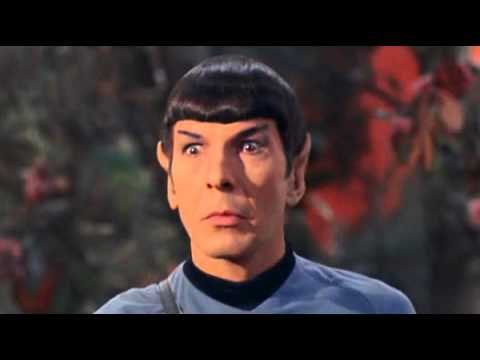

In [14]:
# This function is not timed however it takes ~ 5 minutes some times more or less.
# So when the code finishes executing there is an alarm.

df = comments_scrape(top_submissions)

#play lenord Nemoy saying "beep" for 4 hours
from IPython.display import YouTubeVideo
YouTubeVideo("BE9b3IdTCiY",autoplay=True)

In [23]:
# Get an idea of subreddit comment population representation
print(df['subreddit'].value_counts(normalize=True),('\n\n'),df['subreddit'].value_counts())

politics        0.298286
conspiracy      0.274521
changemyview    0.255172
The_Donald      0.172021
Name: subreddit, dtype: float64 

 politics        24049
conspiracy      22133
changemyview    20573
The_Donald      13869
Name: subreddit, dtype: int64


In [16]:
df.head()

,comments,subreddit
0,"\nAs a reminder, this subreddit [is for civil ...",politics
1,Good job Kentucky!,politics
2,"title should be: ""Lady who refused to do job, ...",politics
3,"From what I remember, this awful bitch owes th...",politics
4,Guess it was God's will ¯\\\_(ツ)\_/¯,politics


### Saving File to Local Drive for later

Because this is a google colab python notebook, we'll want to save our scraped data and load it in later

The data at the end of each section can be saved using this cell. Just change the dataframe you want to save and the name of the file.

**Note** If one wanted to save a file after long computations / data gathering I suggest copying this cell and queing its execution to follow data being scraped or cleaned.

In [0]:
from google.colab import files

with open('reddit_comments_cleaned.csv', 'w') as f:
  f.write(df.to_csv(index=False))

files.download('reddit_comments_cleaned.csv')

In [0]:
df['comments'][0]

'\nAs a reminder, this subreddit [is for civil discussion.](/r/politics/wiki/index#wiki_be_civil)\n\nIn general, be courteous to others. Attack ideas, not users. Personal insults, shill or troll accusations, hate speech, **any** advocating or wishing death/physical harm, and other rule violations can result in a permanent ban. \n\nIf you see comments in violation of our rules, please report them.\n\n***\n\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/politics) if you have any questions or concerns.*'

In [0]:
# lets start cleaning comments


# Clean the text

The process for cleaning the data goes as follows.

1. Expand Contractions

2. Remove Special Characters

3. Remove Stop words

This section needs some work as there is varrying degrees of success in my cleaning of the corpus. This is easily spotted when looking at the final three dimmensional representation of the doc2vec model. I'll note that doing a "bad job" of cleaning this corpus had some interesting observable affects in the latent three dimmensional representation.

Further Work: Add in lemmatization, remove links, remove comments that are constantly repeated words or phrases in sucession (spam), possibly incorporate scoring distinction/threshold.



https://medium.com/ml2vec/using-word2vec-to-analyze-reddit-comments-28945d8cee57

https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72

In [0]:

import nltk.data;
import itertools

import spacy
nlp = spacy.load('en', parse=True, tag=True, entity=True)
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')

from sklearn.neighbors import KDTree;


import os
import re

import logging
import time
import sys
import multiprocessing


import matplotlib.pyplot as plt
from itertools import cycle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
nltk.download('punkt')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle');

In [0]:

df = pd.read_csv('reddit_comments_final1.csv')

In [0]:
!dir

reddit_comments_final.csv  sample_data


In [0]:
df['subreddit'].value_counts()

politics        24058
conspiracy      22111
changemyview    20584
The_Donald      13872
Name: subreddit, dtype: int64

## Expanding Contractions

In [0]:

#Contraction Map is located in at the bottom of the book and is a shameless copy of contraction mappings
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

## Removing Special characters

In [0]:
# BIG THANKS 
def itertools_chain(a):
    return list(itertools.chain.from_iterable(a))
  
def comment_to_sentence(text):
    clean_sentences=[] # this could be removed and possibly eliminate the need for itertools
    #Get the comment
    
    #Normalize tabs and remove newlines
    no_tabs = str(text).replace('\t', ' ').replace('\n', '')

    #Remove all characters except A-Z and a dot.
    alphas_only = re.sub("[^a-zA-Z\.]", " ", no_tabs)

    #Normalize spaces to 1
    multi_spaces = re.sub(" +", " ", alphas_only)

    #Strip trailing and leading spaces
    no_spaces = multi_spaces.strip()

    #Normalize all charachters to lowercase
    clean_text = no_spaces.lower()
    #clean_text = "".join(clean_text)
    #Get sentences from the tokenizer, remove the dot in each.
    #sentences = tokenizer.tokenize(clean_text);
    #sentences = [re.sub("[\.]", "", sentence) for sentence in sentences];
    #sentences = list(map(lambda x:re.sub("[\.]", "", x),sentences))
    #print(sentences)
    clean_sentences.append(clean_text)
    return clean_sentences
    


In [0]:
### Add some of these fields to the previous cleaning function

# This is a different text field cleaning function
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"'\t'", ' ').replace(r'\n', '')
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

In [0]:
# expand contractions
df['comments'] = df['comments'].apply(lambda x:expand_contractions(x))
# Clean comments
df['comments'] = df['comments'].apply(lambda x:comment_to_sentence(x))
#unlist elements 
df['comments']=itertools_chain(df['comments'])

In [0]:
# here we go, each element is a list of lists that were broken up
# We need to combine them so they are in 1 element
df

## Lemmatize the text

In [0]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [0]:
df1['comments']= df1['comments'].apply(lambda x : lemmatize_text(x))


## Remove Stop Words

In [0]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text


In [0]:
df['comments'] = df['comments'].apply(lambda x:remove_stopwords(x))

In [0]:
df['subreddit'].value_counts(normalize=True)

politics        0.298394
conspiracy      0.274245
changemyview    0.255305
The_Donald      0.172056
Name: subreddit, dtype: float64

In [0]:
df = pd.read_csv('reddit_comments_cleaned.csv')

In [0]:
# Visual check for parity
df.info(),df['subreddit'].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80625 entries, 0 to 80624
Data columns (total 2 columns):
comments     80555 non-null object
subreddit    80625 non-null object
dtypes: object(2)
memory usage: 1.2+ MB


(None, politics        0.298394
 conspiracy      0.274245
 changemyview    0.255305
 The_Donald      0.172056
 Name: subreddit, dtype: float64)

In [0]:
df = df[df['comments'].isnull()== False]

# Modeling the Data

Now that we have our comments in a "semi-cleaned" state, we're going to use [Doc2vec](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/doc2vec-lee.ipynb) unsupervised learning technique to generate features for each comment. The main benift of using the a Doc2vec technique is that our data is not labeled in any way. Essentially the only label we have is its classification tag or (subreddit)[Dov2VecPaper](https://cs.stanford.edu/~quocle/paragraph_vector.pdf).

The other main benifit doc2vec serves is similarity. The main goal here is to access how similar or dissimliar a particular communities are from one another. Because doc2vec creates a vector representation for a given comment, similar types of comments should grouped together.

Here are some great articles/tutorials to read that explain Doc2vec and their associated pipelines.

[Sentence Similarity in Python using Doc2Vec](https://kanoki.org/2019/03/07/sentence-similarity-in-python-using-doc2vec/)

[Multi-Class Text Classification with Doc2Vec and t-SNE, a full tutorial.](https://medium.com/@morga046/multi-class-text-classification-with-doc2vec-and-t-sne-a-full-tutorial-55eb24fc40d3) , [Jupyter notebook](https://github.com/ExtraLime/medium-doc2vec/blob/master/doc2vec.ipynb)

[Text Clustering with doc2vec Word Embedding Machine Learning Model](http://ai.intelligentonlinetools.com/ml/text-clustering-doc2vec-word-embedding-machine-learning/)





## Doc 2 Vec



In [0]:
## Doc2Vec imports
import gensim
import collections # I didn't use
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [0]:
df.head()

,comments,subreddit
0,as a reminder this subreddit is for civil disc...,politics
1,good job kentucky,politics
2,title should be lady who refused to do job los...,politics
3,from what i remember this awful bitch owes the...,politics
4,guess it was gods will,politics


In [0]:
#Split the df for training and testing
train, test = train_test_split(df.reset_index(drop=True), test_size=.30, random_state=43)

## Creating Tagged Document

In [0]:
def read_corpus(text, tokens_only=False):
  for i, line in enumerate(text):
    if tokens_only:
      yield gensim.utils.simple_preprocess(line)
    else:
      # For training data, add tags
      yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(line), [i])

In [0]:
## Tag the Training and Test data.
train = train.reset_index(drop=True)

test = test.reset_index(drop=True)

tagged_train = list(read_corpus(train['comments']))

tagged_test = list(read_corpus(test['comments']))

## Training The Doc2Vec Model

In [0]:
#Instantiate the model

model = Doc2Vec(vector_size=100, # 100 should be fine based on the standards
                window=5, #change to 8
                alpha=.025, #initial learning rate
                min_alpha=0.00025, #learning rate drops linearly to this
                min_count=2, #ignores all words with total frequency lower than this.
                dm =1, #algorith 1=distributed memory
                workers=2)#cores to use

#build the vocab on the training data
model.build_vocab(tagged_tr)



iteration 1


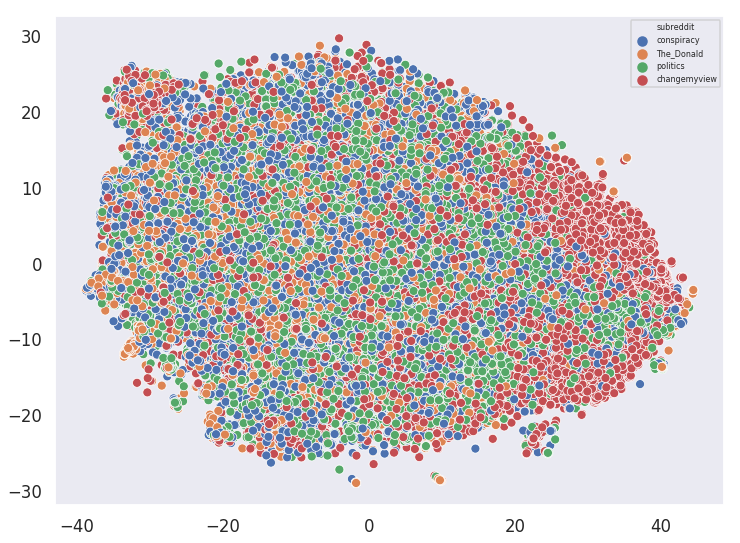

iteration 2
iteration 3
iteration 4
iteration 5
iteration 6


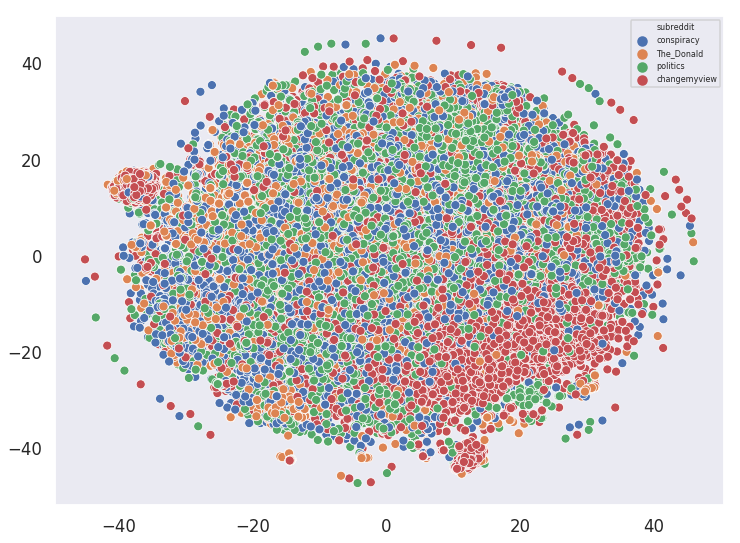

iteration 7
iteration 8
iteration 9
iteration 10
iteration 11


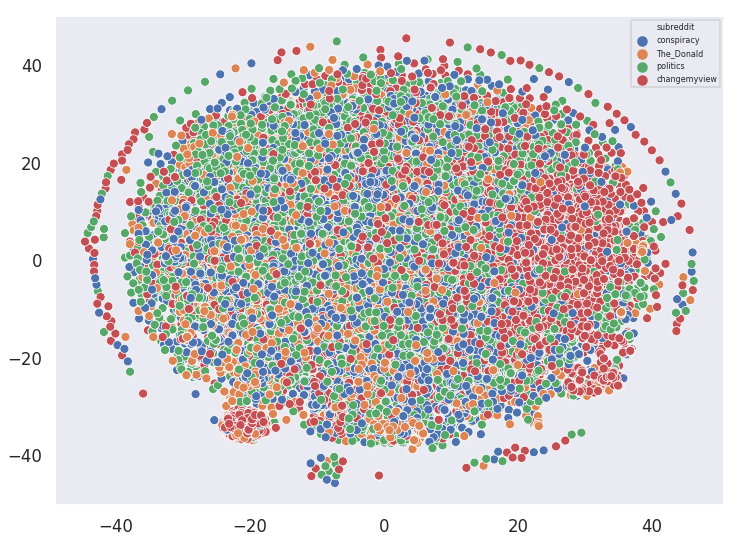

iteration 12
iteration 13
iteration 14
iteration 15
iteration 16


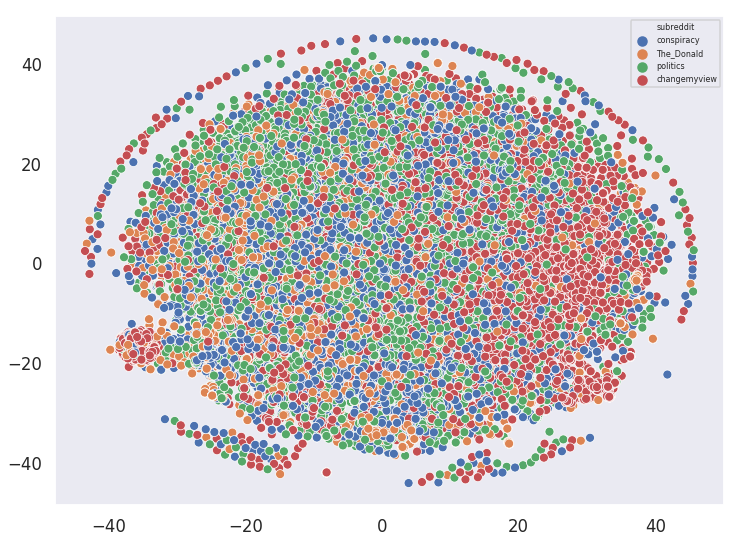

iteration 17
iteration 18
iteration 19
iteration 20
done!
Time: 13101.574803352356


In [0]:


import time
sns.set(style='dark', context='talk')
#Train the model
tsne = TSNE(2, random_state=43)
#max training epochs
max_epochs = 20
sil_scores = []
#train n epochs and save the model
t1 = time.time()
for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch+1))
    model.train(tagged_tr,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha
    #print every 5 epochs
    if epoch%5 == 0:
        vecs = pd.DataFrame([model.docvecs[str(i)] for i in range(len(tagged_tr))])
        tsne_df = tsne.fit_transform(vecs)
        plt.figure(figsize=(12,9))
        sns.scatterplot(x=tsne_df[:,0],y=tsne_df[:,1],hue=train['subreddit'], legend='full')
        plt.legend(prop={'size': 8},bbox_to_anchor=[1,1])
        plt.show()

print("done!")
t2 = time.time()    
model.save("5klects.model")
#print("Model Saved")
print("Time: {}".format(t2-t1))

There are no easily decernable clusters revealed from dimmensional reduction down to 2 dimensional space.

Given how these initial results look

1.  Take the original cleaned data set and remove stop words as well as lemmatize the data
2. Understand if the tagged document is working correctly. Currently tags are sequencial integers and not the document category
3.  Represent the data to doc2vec differently
  *  join all text per sub reddit into a single "document". This would yield poor results for any skip gram type of analysis
 

In [0]:
tagged_tr[0]

TaggedDocument(words=['rain', 'or', 'shower.overwhelming', 'heat', 'or', 'shrinking', 'cold', '.', 'i', 'never', 'holstered.my', 'dick', 'has', 'always', 'been', 'out', '.', 'watch', 'me', 'harambe', 'senpai', '.', 'i', 'do', 'this', 'for', 'you'], tags=['0'])

# [PART 2 Continued Here](https://github.com/zdwhite/Thinkful-Unit-4/blob/master/Reddit%20Doc2Vec%20Training%20and%20Viz.ipynb)

# Other Code

In [0]:
## This is a contraction map shamlessly taken from another project
#### REMINDER FIND SOURCE

CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}